![Banner logo](https://raw.githubusercontent.com/CitrineInformatics/community-tools/master/templates/fig/citrine_banner_2.png)

# PyCC Sequential Learning Tutorial

*Authors: Edward Kim, Enze Chen*

In this notebook, we will cover how to perform **sequential learning** (SL) using the [Citrination API](http://citrineinformatics.github.io/python-citrination-client/). [Sequential learning](https://citrine.io/platform/sequential-learning/) is the key workflow which allows machine learning algorithms and in-lab experiments to iteratively inform each other.

To replace the need for an actual laboratory, this notebook uses a simple *toy function* that allows for "measurements" on the data.

**NOTE**: If you want to run the sequential learning code in the final part of this tutorial on the public version of Citrination (https://citrination.com), then you will need an Admin account to run design jobs.

## Table of contents
1. [Learning outcomes](#Learning-outcomes)
1. [Background knowledge](#Background-knowledge)
1. [Imports](#Python-package-imports)
1. [Initialization](#Initialize-the-PyCC)
1. [Data generation](#Data-generation)
1. [Design](#Running-design)
1. [Visualize results](#Examining-the-results)
1. [Conclusion](#Conclusion)
1. [Additional resources](#Additional-resources)

## Learning outcomes

[Back to ToC](#Table-of-contents)

By the end of this tutorial, you will know how to:

- Use PyCC end to end, from uploading an initial dataset to running SL.
- Understand how to configure SL parameters to match your laboratory setup.
- Asynchronously issue SL jobs to Citrination's backend.

## Background knowledge

[Back to ToC](#Table-of-contents)

In order to get the most out of this tutorial, you should already be familiar with the following:

- Create and access datasets through the API ([tutorial](1_data_client_api_tutorial.ipynb)).
- Create and access data views through the API ([tutorial](2_data_views_api_tutorial.ipynb)).
- What the data views [front-end UI](https://citrination.com/data_views) looks like, particularly the Design interface.

## Python package imports

[Back to ToC](#Table-of-contents)

This notebook uses some convenience functions to wrap several API endpoints. These are listed in the file [`sequential_learning_wrappers.py`](./sequential_learning_wrappers.py) and imported below. Review the docstrings and code in that file to learn more.

In [1]:
# Standard packages
import os
import uuid

# Third-party packages
from sequential_learning_wrappers import *   # Helper functions to wrap several API endpoints together
%matplotlib inline

## Initialize the PyCC

[Back to ToC](#Table-of-contents)

Make sure to properly set your **environment variable** to hold your API key.

In [2]:
site = "https://citrination.com" # site you want to access; we'll use the public site
client = CitrinationClient(api_key=os.environ.get("CITRINATION_API_KEY"), site=site)

## Data generation

[Back to ToC](#Table-of-contents)

Since we aren't using a real laboratory, we need access to a quick way to generate "correct" measurements. A simple placeholder here is to use a function that sums the squares of its inputs. The goal, in this case, will be to find the global minimum located at the origin. 

In a real example, we could minimize or maximize any output: compressive strengths, conductivities, and so on.

### `toy_func()`
This function takes a list of values and sums the squares of the values.

In [3]:
def toy_func(inputs):
    return np.sum(np.square(inputs))

In [4]:
# Generate random inputs and outputs
toy_x = [np.random.normal(loc=3.0, scale=1.0, size=(1, 2))[0] for x in range(20)]
toy_y = [toy_func(x) for x in toy_x]

initial_best_measured_value = min(toy_y)

print("Best (lowest) value in initial training set: {}".format(initial_best_measured_value))

Best (lowest) value in initial training set: 4.982739167743289


Now we can plot the initial training set, and color it by the function value.

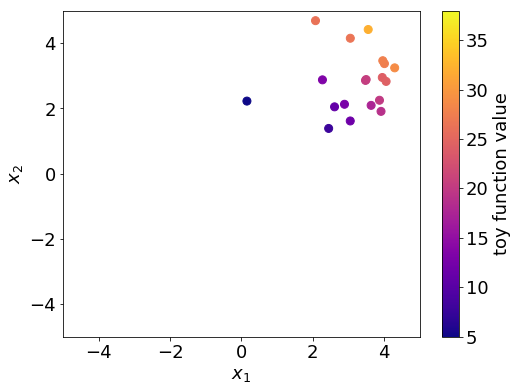

In [5]:
# Plot initial training set, colored by toy function values
plt.rcParams.update({'figure.figsize':(8, 6), 'font.size':18, 'lines.markersize':8})
plt.scatter(np.array(toy_x)[:,0], np.array(toy_x)[:,1],
            c=toy_y, cmap=plt.cm.plasma)
plt.colorbar(label='toy function value')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.show()

In [ ]:
# Write a PIF JSON dataset file
random_string = str(uuid.uuid4())[:6]
output_file = 'toy_initial_dataset_{}.json'.format(random_string)
write_dataset_from_func(toy_func, output_file, toy_x)

In [ ]:
# Make a dataset, upload to Citrination, return/print the ID
dataset_name = output_file.split('.')[0]
dataset_id = upload_data_and_get_id(
    client,
    dataset_name,
    output_file,
    create_new_version=True,
)
print("Dataset created: {}".format(dataset_id))
print("Dataset URL: {}/datasets/{}".format(site, dataset_id))

In [ ]:
# Make a data view on Citrination, return/print the ID
view_name = 'toy_view_{}'.format(random_string)
view_id = build_view_and_get_id(client, dataset_id, view_name, view_desc="toy test view",
                      input_keys=["Property x1", "Property x2"], output_keys=["Property y"])

print("Data view created: {}".format(view_id))
print("Data view URL: {}/data_views/{}".format(site, view_id))

If this is not your first time running this notebook, you can change the following variables to match what you've already created.

In [ ]:
# dataset_id = 176716
# view_id = 9673
# print("Existing dataset URL: {}/datasets/{}".format(site, dataset_id))
# print("Existing data view URL: {}/data_views/{}".format(site, view_id))

## Running design

[Back to ToC](#Table-of-contents)

Now we call a function that runs the SL process. In short, we run a loop where we do the following:

1. Submit a design run (and poll status w/ wait times).
1. Get best candidates and record predicted results.
1. Measure candidates (using toy function evaluation) and record measured results.
1. Add candidates to dataset.
1. Retrain on dataset (and poll status w/ wait times).
1. Repeat until maximum number of iterations reached.

Detailed comments can be found in the [function docstring](sequential_learning_wrappers.py).

In [ ]:
best_sl_pred_vals, best_sl_measured_vals = run_sequential_learning(
    client=client,
    view_id=str(view_id),
    dataset_id=str(dataset_id),
    num_candidates_per_iter=10,
    design_effort=10,
    wait_time=10,
    num_sl_iterations=5,
    input_properties=["Property x1", "Property x2"],
    target=["Property y", "Min"],
    print_output=True,
    true_function=toy_func,
    score_type="MLI"
)

## Examining the results

[Back to ToC](#Table-of-contents)

Finally, we can plot the results against the number of SL iterations. 
* **Blue**: The best measured candidate. Lower = better for function minimization.
* **Yellow**: The best predicted candidate.
* **Green**: The uncertainty in the prediction. Note this decreases as we progress.
* **Black**: The best value in the training set.

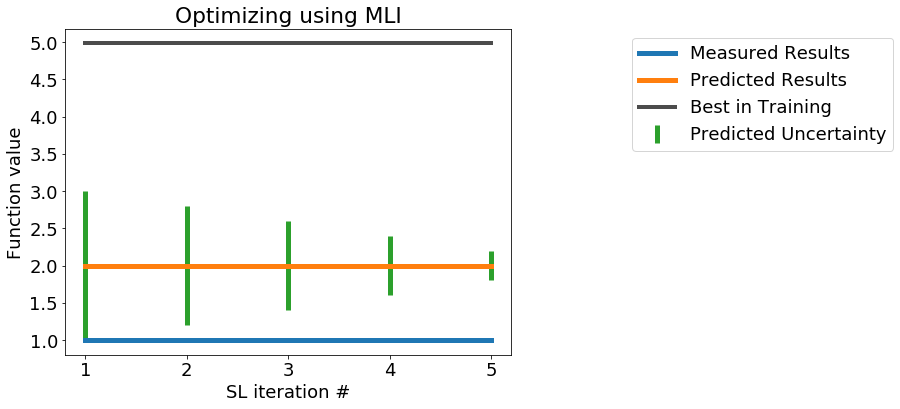

In [9]:
plot_sl_results(best_sl_measured_vals, best_sl_pred_vals, initial_best_measured_value)

## Conclusion

[Back to ToC](#Table-of-contents)

To recap, this notebook went through the steps for running SL using the API.
1. First, we created and uploaded an initial dataset.
1. Then, we created a data view and trained the model.
1. We ran the SL process, measuring and updating new candidates after each iteration.
1. Finally we examined our SL results.

## Additional resources

[Back to ToC](#Table-of-contents)

It's now possible to conduct the major aspects of the Citrination workflow through the API, which should increase the speed and flexibility of informatics approaches. Some other topics that might interest you include:
* [DataClient](http://citrineinformatics.github.io/python-citrination-client/tutorial/data_examples.html) - This allows you to create datasets and upload PIF data (only) using the API.
  * There is also a corresponding [tutorial](1_data_client_api_tutorial.ipynb).

* [DataViewsClient](http://citrineinformatics.github.io/python-citrination-client/tutorial/view_examples.html) - This allows you to build views (i.e. train ML models) using the API.
  * There is also a corresponding [tutorial](2_data_views_api_tutorial.ipynb).
  
* [ModelsClient](http://citrineinformatics.github.io/python-citrination-client/tutorial/models_examples.html) - This allows you to submit predict and design runs using the API.
  * There is also a corresponding [tutorial](3_models_client_api_tutorial.ipynb).